# Skin lesion segmentation
Skin cancer, resulting from the exposure of skin to ultraviolet radioactivity released from the sun, is the most common type of cancer around the world. Melanoma, Basal cell, and Squamous cell carcinoma are considered the main types of cancer, with Melanoma being the most dangerous one.

Here, the HAM 10000 dataset is used. This dataset consists of 10015 dermoscopic images of pigmented skin lesions, classified into seven categories, Actinic keratoses and intraepithelial carcinoma / Bowen's disease, basal cell carcinoma, benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratosis), dermatofibroma, melanoma, melanocytic nevi,  and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage). The lesions are confirmed through histopathology, follow-up examination, expert consensus, or in-vivo confocal microscopy. This dataset also provides binary segmentation masks of these dermatoscopic images, which together with the HAM10000 diagnosis metadata can be used for object detection or semantic segmentation.

In [1]:
%matplotlib inline
import csv
import os
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torchvision
from torchvision import models, transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### 1- Preprocessing and data cleaning

##### The first step is to create an image path dictionary by merging images from both folders HAM10000_images_part_1 and HAM10000_images_part_2. Also, we created mask path dictionary.

In [2]:
base_skin_dir = os.path.join("skin_cancer/Final_project")

# Merging images from folders
image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x 
                   for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

mask_path_dict = {os.path.splitext(os.path.basename(x))[0]: x 
                   for x in glob(os.path.join(base_skin_dir, '*', '*.png'))}

# Creating a dictionary
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

skin_df['mask_id'] = skin_df['image_id'] + '_segmentation'
skin_df['mask_path'] = skin_df['mask_id'].map(mask_path_dict.get)

skin_df['path'] = skin_df['image_id'].map(image_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,mask_id,mask_path,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ISIC_0027419_segmentation,skin_cancer/Final_project/HAM10000_segmentatio...,skin_cancer/Final_project/HAM10000_images_part...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ISIC_0025030_segmentation,skin_cancer/Final_project/HAM10000_segmentatio...,skin_cancer/Final_project/HAM10000_images_part...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ISIC_0026769_segmentation,skin_cancer/Final_project/HAM10000_segmentatio...,skin_cancer/Final_project/HAM10000_images_part...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ISIC_0025661_segmentation,skin_cancer/Final_project/HAM10000_segmentatio...,skin_cancer/Final_project/HAM10000_images_part...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633_segmentation,skin_cancer/Final_project/HAM10000_segmentatio...,skin_cancer/Final_project/HAM10000_images_part...,Benign keratosis-like lesions,2


##### Finding missing values

In [4]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
mask_id           0
mask_path         0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

##### Filling missing values with the mean of age of patients

In [5]:
skin_df['age'].fillna((skin_df['age'].mean().round(0)), inplace=True)
skin_df.isnull().sum()

/tmp/ipykernel_3669329/2214850127.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  skin_df['age'].fillna((skin_df['age'].mean().round(0)), inplace=True)


lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
mask_id          0
mask_path        0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [6]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
mask_id           object
mask_path         object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


### 2- Exploring and visualizing the distribution of different features

/tmp/ipykernel_3669329/3490945391.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=80)


Text(0.5, 1.0, 'Distribution of cell types')

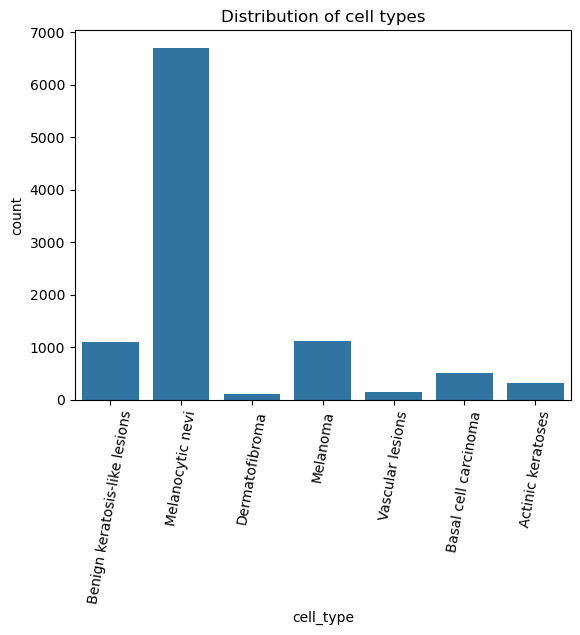

In [7]:
chart = sns.countplot(x='cell_type', data=skin_df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=80)
chart.set_title('Distribution of cell types')

##### According to the plot, Melanocytic nevi is the most common type of skin cancer.

##### In the above plot, the distribution of diagnosis techniques are illustrated. These techniques are as follows:
1. Histopathology(Histo): Histopathologic diagnosis od lesions performed by specialized dermatopathologists.
2. Follow-up: If nevi monitored by digital dermatoscopy did not show any changes during 3 follow-up visits or 1.5 years biologists accepted this as evidence of biologic benignity. Only nevi, but no other benign diagnoses were labeled with this type of ground-truth because dermatologists usually do not monitor dermatofibromas, seborrheic keratoses, or vascular lesions.
3. Consensus: For typical benign cases without histopathology or followup biologists provide an expert-consensus rating of authors PT and HK. They applied the consensus label only if both authors independently gave the same unequivocal benign diagnosis. Lesions with this type of groundtruth were usually photographed for educational reasons and did not need further follow-up or biopsy for confirmation.
4. Confocal: Reflectance confocal microscopy is an in-vivo imaging technique with a resolution at near-cellular level , and some facial benign with a grey-world assumption of all training-set images in Lab-color space before and after manual histogram changes.

/tmp/ipykernel_3669329/289870349.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=60)


Text(0.5, 1.0, 'Distribution of skin cancer regions')

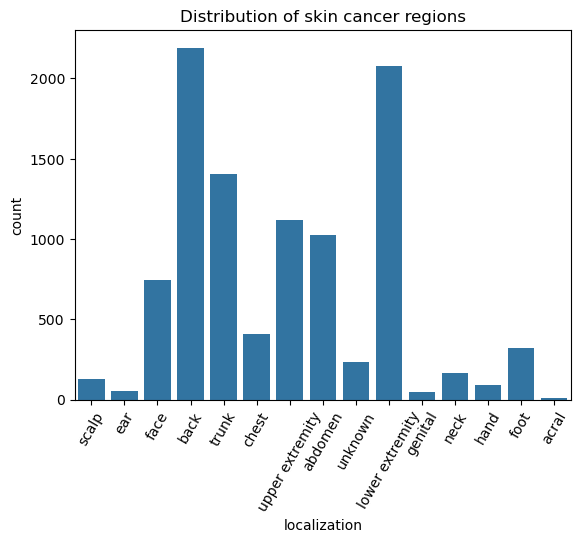

In [8]:
chart = sns.countplot(x='localization', data=skin_df)
chart.set_xticklabels(chart.get_xticklabels(), rotation=60)
chart.set_title('Distribution of skin cancer regions')

##### As we can see, lower extremity and back regions are the most common skin cancer locations. 

Text(0.5, 1.0, 'Distribution of age')

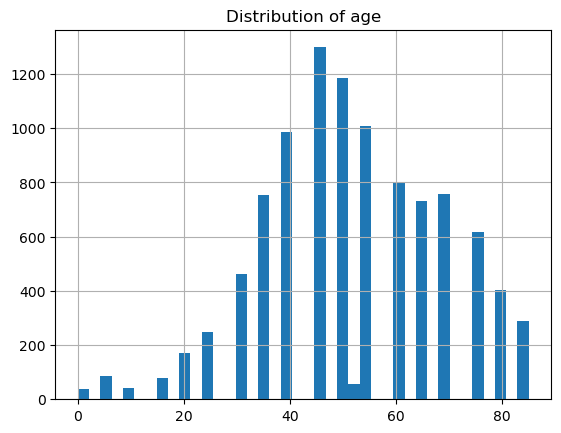

In [9]:
plot = skin_df['age'].hist(bins=40)
plot.set_title('Distribution of age')

##### This plot shows that a large number of patients are between 30 to 60 years old.

Text(0.5, 1.0, 'Distribution of sex')

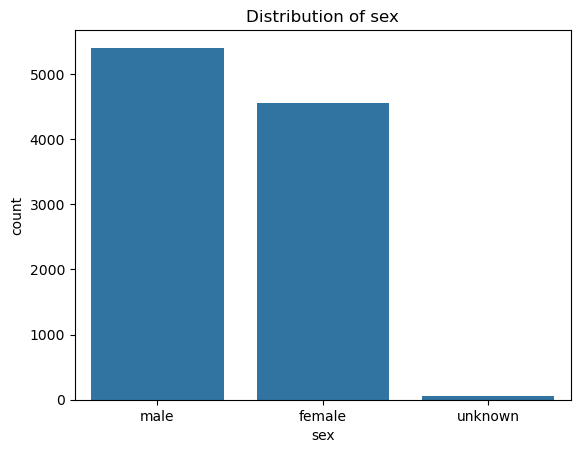

In [10]:
sns.countplot(x='sex', data=skin_df).set_title('Distribution of sex')

Text(0.5, 1.0, 'Distribution of sex by cell types')

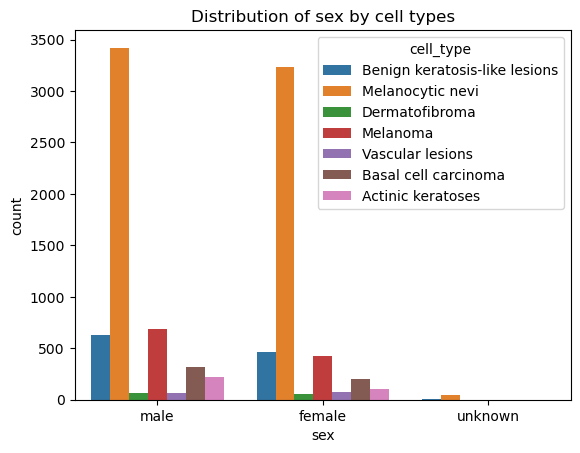

In [11]:
sns.countplot(x='sex', hue='cell_type', data=skin_df).set_title('Distribution of sex by cell types')

### 3- Creating datasets

In [12]:
class SkinLesion_dataset(Dataset):
    def __init__(self, df, transform=None):
        
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image = np.array(Image.open(self.df['path'][index]))
        label = torch.tensor(int(self.df['cell_type_idx'][index]))
        mask = np.array(Image.open(self.df['mask_path'][index]).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
           

        return image, mask, label

### 4- Splitting the data

In [13]:
train_df, val_df = train_test_split(skin_df, test_size=0.2, random_state=42)
print("Train data:", train_df.shape)
print("Validation data:", val_df.shape)

Train data: (8012, 12)
Validation data: (2003, 12)


In [14]:
train_df = train_df.reset_index()
val_df = val_df.reset_index()

### 5- Creating Dataloaders

In [15]:
Image_height = 224
Image_width = 224

train_transform = A.Compose([
    A.Resize(height=Image_height, width=Image_width),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    ToTensorV2()
])
    

val_transform = A.Compose([
    A.Resize(height=Image_height, width=Image_width),
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    ToTensorV2()
])

In [16]:
batch_size = 32

train_dataset = SkinLesion_dataset(df=train_df, transform=train_transform) 
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=1, shuffle=True)

val_dataset = SkinLesion_dataset(df=val_df, transform=val_transform) 
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=1, shuffle=False)

### 5- U-Net model

In [17]:
# U-Net implementation

class Conv_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
    
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False), #bias=False as we are going to use batch normalization
                                                                                                  #first few iterations will go on to cancel this bias and slow down the training.
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
    
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
    
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_block(x)


class Encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv = Conv_block(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, p

class Decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = Conv_block(out_channels+out_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder part
        self.e1 = Encoder_block(3, 64)
        self.e2 = Encoder_block(64, 128)
        self.e3 = Encoder_block(128, 256)
        self.e4 = Encoder_block(256, 512)

        # Bottleneck block
        self.bottleneck = Conv_block(512, 1024)

        # Decoder part
        self.d1 = Decoder_block(1024, 512)
        self.d2 = Decoder_block(512, 256)
        self.d3 = Decoder_block(256, 128)
        self.d4 = Decoder_block(128, 64)

        # Classifier
        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        bottle_neck = self.bottleneck(p4)

        d1 = self.d1(bottle_neck, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        output = self.output(d4)
        
        return output

        
# Check to see if it is working    
# if __name__ == "__main__":
#     inputs = torch.randn((2, 3, 224, 224))

#     model = UNet()
#     y = model(inputs)
#     print(y.shape)

### 6- Model training

In [18]:
def train_fn(model, loader, criterion, optimizer, scaler):
    loop = tqdm(loader) # to provide progress bar

    for batch_idx, (data, masks, labels) in enumerate(loop):
        data = data.to(device)
        masks = masks.float().unsqueeze(1).to(device)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = criterion(predictions, masks)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item()) # to add loss values to the bar

In [19]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def check_accuracy(loader, model):
    num_corrects = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    
    with torch.no_grad():
        for data, masks, labels in loader:
            data = data.to(device)
            masks = masks.to(device).unsqueeze(1) # label doesn't have channel as it is gray scale
            
            preds = torch.sigmoid(model(data))
            preds = (preds > 0.5).float()
            
            num_corrects += (preds == masks).sum()
            num_pixels += torch.numel(preds)
    
            dice_score += (2 * (preds * masks).sum()) / ((preds + masks).sum() + 1e-8)
    
    print(f"Got {num_corrects}/{num_pixels} with acc {num_corrects/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def save_predictions_as_imgs(loader, model, folder="skin_cancer/Final_project/segmented_images/"):
    model.eval()
    for idx, (x, y, z) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            
        torchvision.utils.save_image(preds, f"{folder}/ISIC_{idx}_segmentation.png")
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()

In [20]:
model = UNet().to(device)

Load_model = False
learning_rate = 1e-4
num_epochs = 50

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

if Load_model:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)
    
scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
    train_fn(model, train_loader, criterion, optimizer, scaler)

    # Save model
    checkpoint = {
        "state dict": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(val_loader, model)

    # save images
    save_predictions_as_imgs(val_loader, model, folder="skin_cancer/Final_project/segmented_images/") 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.01s/it, loss=0.205]


=> Saving checkpoint
Got 93852296/100502528 with acc 93.38
Dice score: 0.8779394030570984


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.00s/it, loss=0.134]


=> Saving checkpoint
Got 94472122/100502528 with acc 94.00
Dice score: 0.8943231105804443


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.01s/it, loss=0.132]


=> Saving checkpoint
Got 95632969/100502528 with acc 95.15
Dice score: 0.9118542075157166


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:13<00:00,  1.01s/it, loss=0.0768]


=> Saving checkpoint
Got 96259122/100502528 with acc 95.78
Dice score: 0.9206624627113342


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:13<00:00,  1.01s/it, loss=0.0968]


=> Saving checkpoint
Got 96352703/100502528 with acc 95.87
Dice score: 0.9213415384292603


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:11<00:00,  1.00s/it, loss=0.108]


=> Saving checkpoint
Got 96054482/100502528 with acc 95.57
Dice score: 0.918497622013092


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.00s/it, loss=0.219]


=> Saving checkpoint
Got 96373719/100502528 with acc 95.89
Dice score: 0.9219582080841064


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.00s/it, loss=0.102]


=> Saving checkpoint
Got 96454199/100502528 with acc 95.97
Dice score: 0.9245338439941406


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.01s/it, loss=0.0718]


=> Saving checkpoint
Got 96452289/100502528 with acc 95.97
Dice score: 0.9240015149116516


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.01s/it, loss=0.0756]


=> Saving checkpoint
Got 96525274/100502528 with acc 96.04
Dice score: 0.9253815412521362


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.00s/it, loss=0.112]


=> Saving checkpoint
Got 96774973/100502528 with acc 96.29
Dice score: 0.9304909706115723


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.01s/it, loss=0.133]


=> Saving checkpoint
Got 96588503/100502528 with acc 96.11
Dice score: 0.9272580146789551


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:13<00:00,  1.01s/it, loss=0.239]


=> Saving checkpoint
Got 96733469/100502528 with acc 96.25
Dice score: 0.9302515983581543


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:13<00:00,  1.01s/it, loss=0.106]


=> Saving checkpoint
Got 96744011/100502528 with acc 96.26
Dice score: 0.9308804869651794


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.01s/it, loss=0.107]


=> Saving checkpoint
Got 96582423/100502528 with acc 96.10
Dice score: 0.9275187253952026


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:17<00:00,  1.03s/it, loss=0.0521]


=> Saving checkpoint
Got 96774338/100502528 with acc 96.29
Dice score: 0.9290149211883545


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.01s/it, loss=0.112]


=> Saving checkpoint
Got 96682920/100502528 with acc 96.20
Dice score: 0.9301038980484009


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:13<00:00,  1.01s/it, loss=0.106]


=> Saving checkpoint
Got 96821821/100502528 with acc 96.34
Dice score: 0.9319216012954712


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:14<00:00,  1.01s/it, loss=0.16]


=> Saving checkpoint
Got 96853927/100502528 with acc 96.37
Dice score: 0.9323551058769226


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:13<00:00,  1.01s/it, loss=0.056]


=> Saving checkpoint
Got 96943223/100502528 with acc 96.46
Dice score: 0.9332507252693176


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:13<00:00,  1.01s/it, loss=0.0914]


=> Saving checkpoint
Got 96913428/100502528 with acc 96.43
Dice score: 0.933502733707428


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:13<00:00,  1.01s/it, loss=0.075]


=> Saving checkpoint
Got 96850844/100502528 with acc 96.37
Dice score: 0.9323247671127319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.01s/it, loss=0.0712]


=> Saving checkpoint
Got 96944074/100502528 with acc 96.46
Dice score: 0.9330337047576904


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:13<00:00,  1.01s/it, loss=0.135]


=> Saving checkpoint
Got 96872678/100502528 with acc 96.39
Dice score: 0.9329999685287476


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.01s/it, loss=0.0627]


=> Saving checkpoint
Got 96542011/100502528 with acc 96.06
Dice score: 0.926764190196991


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.01s/it, loss=0.12]


=> Saving checkpoint
Got 97031624/100502528 with acc 96.55
Dice score: 0.9348448514938354


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:13<00:00,  1.01s/it, loss=0.101]


=> Saving checkpoint
Got 97038844/100502528 with acc 96.55
Dice score: 0.9354384541511536


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.01s/it, loss=0.0656]


=> Saving checkpoint
Got 97034119/100502528 with acc 96.55
Dice score: 0.9355525970458984


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.01s/it, loss=0.0771]


=> Saving checkpoint
Got 97059108/100502528 with acc 96.57
Dice score: 0.9355050921440125


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.01s/it, loss=0.108]


=> Saving checkpoint
Got 97044732/100502528 with acc 96.56
Dice score: 0.9359189867973328


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.01s/it, loss=0.0838]


=> Saving checkpoint
Got 97001772/100502528 with acc 96.52
Dice score: 0.9350548982620239


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:13<00:00,  1.01s/it, loss=0.121]


=> Saving checkpoint
Got 96939259/100502528 with acc 96.45
Dice score: 0.9338657855987549


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.01s/it, loss=0.0696]


=> Saving checkpoint
Got 97120470/100502528 with acc 96.63
Dice score: 0.9368396997451782


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:13<00:00,  1.01s/it, loss=0.104]


=> Saving checkpoint
Got 97242551/100502528 with acc 96.76
Dice score: 0.9389041066169739


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:12<00:00,  1.01s/it, loss=0.0988]


=> Saving checkpoint
Got 97209413/100502528 with acc 96.72
Dice score: 0.9384602904319763


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:13<00:00,  1.01s/it, loss=0.0927]


=> Saving checkpoint
Got 97166363/100502528 with acc 96.68
Dice score: 0.9373031258583069


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:13<00:00,  1.01s/it, loss=0.0648]


=> Saving checkpoint
Got 96664276/100502528 with acc 96.18
Dice score: 0.9277188777923584


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:18<00:00,  1.03s/it, loss=0.195]


=> Saving checkpoint
Got 97148342/100502528 with acc 96.66
Dice score: 0.9376257658004761


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:19<00:00,  1.03s/it, loss=0.0881]


=> Saving checkpoint
Got 97219138/100502528 with acc 96.73
Dice score: 0.9393852949142456


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:19<00:00,  1.03s/it, loss=0.0659]


=> Saving checkpoint
Got 97117980/100502528 with acc 96.63
Dice score: 0.9371389746665955


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:18<00:00,  1.03s/it, loss=0.0405]


=> Saving checkpoint
Got 97134523/100502528 with acc 96.65
Dice score: 0.937419593334198


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:18<00:00,  1.03s/it, loss=0.0582]


=> Saving checkpoint
Got 96933629/100502528 with acc 96.45
Dice score: 0.9327870607376099


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:20<00:00,  1.04s/it, loss=0.0575]


=> Saving checkpoint
Got 97130855/100502528 with acc 96.65
Dice score: 0.9373189210891724


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:20<00:00,  1.04s/it, loss=0.0518]


=> Saving checkpoint
Got 97081593/100502528 with acc 96.60
Dice score: 0.9365075826644897


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:18<00:00,  1.03s/it, loss=0.0652]


=> Saving checkpoint
Got 97197272/100502528 with acc 96.71
Dice score: 0.9376082420349121


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:18<00:00,  1.03s/it, loss=0.0371]


=> Saving checkpoint
Got 97228667/100502528 with acc 96.74
Dice score: 0.9389957189559937


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:18<00:00,  1.03s/it, loss=0.0714]


=> Saving checkpoint
Got 97214861/100502528 with acc 96.73
Dice score: 0.9394228458404541


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:18<00:00,  1.03s/it, loss=0.0863]


=> Saving checkpoint
Got 97190088/100502528 with acc 96.70
Dice score: 0.9392251372337341


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:18<00:00,  1.03s/it, loss=0.216]


=> Saving checkpoint
Got 97257147/100502528 with acc 96.77
Dice score: 0.9394383430480957


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:18<00:00,  1.03s/it, loss=0.103]


=> Saving checkpoint
Got 97207729/100502528 with acc 96.72
Dice score: 0.9383165836334229
